In [1]:
import os
import glob
import numpy as np
import cv2
import cvlib as cv
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

In [2]:
batch_size = 32
img_height = 224
img_width  = 224
base_lr = 1e-5
epochs  = 50

path = './data'

In [3]:
train_datagen = ImageDataGenerator(
#     rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.3,
    fill_mode='nearest',
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(
#     rescale=1./255,
    validation_split=0.3,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    path+'/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=93,
    subset='training')

valid_generator = valid_datagen.flow_from_directory(
    path+'/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=93,
    subset='validation')

Found 7037 images belonging to 2 classes.
Found 3014 images belonging to 2 classes.


In [4]:
img_shape = (img_height, img_width, 3)

base_model = MobileNetV2(input_shape=img_shape,
                        include_top=False,
                        weights='imagenet')
base_model.trainable = False

In [5]:
x = base_model.output
x = layers.AveragePooling2D(pool_size=(5, 5), strides=1, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(2, activation='softmax')(x)
print(x)

Tensor("dense/Softmax:0", shape=(None, 2), dtype=float32)


In [6]:
model = keras.models.Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr, decay=base_lr/epochs),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/MobileNet_test1.h5',
    monitor='val_loss',
    save_best_only=True)
]

history = model.fit(
          train_generator,
          validation_data=valid_generator,
          epochs=epochs,
          callbacks=callbacks_list
)

Epoch 1/50
220/220 [==============================] - 88s 400ms/step - loss: 0.5654 - accuracy: 0.7299 - val_loss: 0.4266 - val_accuracy: 0.8059
Epoch 2/50
220/220 [==============================] - 85s 388ms/step - loss: 0.3893 - accuracy: 0.8310 - val_loss: 0.3799 - val_accuracy: 0.8315
Epoch 3/50
220/220 [==============================] - 84s 382ms/step - loss: 0.3425 - accuracy: 0.8556 - val_loss: 0.3531 - val_accuracy: 0.8451
Epoch 4/50
220/220 [==============================] - 86s 391ms/step - loss: 0.3250 - accuracy: 0.8643 - val_loss: 0.3377 - val_accuracy: 0.8543
Epoch 5/50
220/220 [==============================] - 85s 386ms/step - loss: 0.3080 - accuracy: 0.8690 - val_loss: 0.3309 - val_accuracy: 0.8640
Epoch 6/50
220/220 [==============================] - 82s 371ms/step - loss: 0.3007 - accuracy: 0.8764 - val_loss: 0.3242 - val_accuracy: 0.8673
Epoch 7/50
220/220 [==============================] - 81s 369ms/step - loss: 0.2919 - accuracy: 0.8816 - val_loss: 0.3200 - val_ac

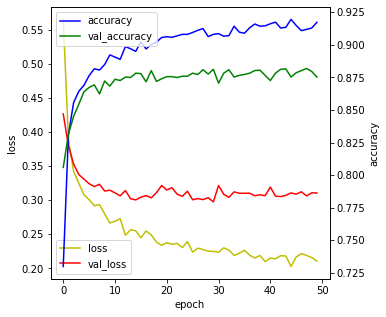

In [8]:
fig, loss_ax = plt.subplots(figsize=(5,5))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')
# loss_ax.set_ylim([0, 1])

acc_ax.plot(history.history['accuracy'], 'b', label='accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val_accuracy')
# acc_ax.set_ylim([0, 1])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='lower left')
acc_ax.legend(loc='upper left')
plt.show()